In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer

# Informe T√©cnico de Miner√≠a de Datos: An√°lisis del Clima en Australia

Este notebook se organiza en base a las dos primeras fases de la metodolog√≠a CRISP-DM: **Business Understanding** y **Data Understanding**. Adem√°s, se introduce la idea de construir un ‚Äú√çndice de Riesgo Clim√°tico por ciudad‚Äù que responda a la pregunta: ‚Äú¬øQu√© regiones de Australia tienen m√°s riesgo de fen√≥menos extremos?‚Äù mediante un score que combine:

- **Velocidad de R√°faga (WindGustSpeed)**
- **M√°xima Temperatura (MaxTemp)**
- **Baja Humedad**
- **Alta Precipitaci√≥n (Rainfall)**

El √≠ndice se escalara y presentar√° por ubicaci√≥n, generando un ranking de ciudades ‚Äúm√°s extremas clim√°ticamente‚Äù y, para una temporada o fecha espec√≠fica, se indicar√°n cu√°les son las ciudades con mayor riesgo y qu√© factores son los determinantes.

---

## 1. Business Understanding

### 1.1. Introducci√≥n

El objetivo de este an√°lisis es sentar las bases para el desarrollo de modelos predictivos y la construcci√≥n de un √≠ndice de riesgo clim√°tico. Este √≠ndice ayudar√° a identificar las regiones de Australia con mayor riesgo de fen√≥menos extremos, lo que es fundamental para la toma de decisiones estrat√©gicas en √°reas como la agricultura, el turismo y la gesti√≥n de riesgos.

### 1.2. Objetivos del Negocio y KPIs

- **Objetivos del Negocio:**
  - Mejorar la capacidad predictiva del clima mediante modelos que anticipen condiciones adversas.
  - Optimizar recursos y planificaciones basadas en condiciones clim√°ticas espec√≠ficas.
  - Reducir riesgos al identificar regiones vulnerables a fen√≥menos extremos.

- **KPIs Relevantes:**
  - N√∫mero de d√≠as con precipitaciones intensas.
  - Promedio y variabilidad de temperaturas (MinTemp y MaxTemp).
  - Frecuencia de eventos extremos (outliers en Rainfall y RISK_MM).
  - √çndices de humedad y presi√≥n que ayuden a identificar cambios bruscos en el clima.

## 2. Data Understanding

### 2.1. Carga y Visualizaci√≥n de Datos

In [2]:
df = pd.read_csv('weatherAUS.csv')

In [3]:
print("Primeras filas del dataset:")
print(df.head())

Primeras filas del dataset:
         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  Pressure9am  \
0           W           44.0          W  ...        22.0       1007.7   
1         WNW           44.0        NNW  ...        25.0       1010.6   
2         WSW           46.0          W  ...        30.0       1007.6   
3          NE           24.0         SE  ...        16.0       1017.6   
4           W           41.0        ENE  ...        33.0       1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RISK_

Al analizar las primeras filas del dataset mediante `df.head()` nos permitio tener visi√≥n general de la estructura y contenido de los datos clim√°ticos recopilados. A continuaci√≥n, realizamos algunas algunas observaciones:

- El dataset est√° compuesto por 24 columnas, que incluyen variables de tipo fecha (`Date`), categ√≥ricas como `Location`, `WindGustDir`, `WindDir9am`, `WindDir3pm`, y m√∫ltiples columnas num√©ricas relacionadas con fen√≥menos clim√°ticos (`MinTemp`, `MaxTemp`, `Rainfall`, etc.).

- La variable `RainTomorrow` parece representar una etiqueta binaria o categ√≥rica, lo que sugiere que este dataset pudo haber sido utilizado originalmente para tareas de clasificaci√≥n. Aunque no es nuestro enfoque principal, podr√≠a utilizarse m√°s adelante como referencia o comparaci√≥n.

- La columna `Date` est√° correctamente formateada y lista para extracci√≥n de componentes temporales como estaci√≥n, mes o a√±o, lo cual es √∫til para an√°lisis estacionales y comparaci√≥n entre ciudades o √©pocas del a√±o.

- La presencia de m√∫ltiples columnas horarias (`WindSpeed9am`, `Humidity3pm`, etc.) indica que los registros clim√°ticos est√°n tomados en distintos momentos del d√≠a, lo que enriquece el an√°lisis, ya que permite estudiar variaciones diurnas y construir m√©tricas como amplitud t√©rmica o cambios en humedad relativa.

- A nivel estructural, el orden de las columnas es coherente y muestra un dise√±o de dataset limpio y manejable. No se observan nombres confusos, abreviaturas ambiguas ni columnas in√∫tiles a primera vista.

In [4]:
print("\nEstad√≠sticas descriptivas:")
print(df.describe())


Estad√≠sticas descriptivas:
             MinTemp        MaxTemp       Rainfall   Evaporation  \
count  141556.000000  141871.000000  140787.000000  81350.000000   
mean       12.186400      23.226784       2.349974      5.469824   
std         6.403283       7.117618       8.465173      4.188537   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.800000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  74377.000000  132923.000000  140845.000000  139563.000000   
mean       7.624853      39.984292      14.001988      18.637576   
std        3.781525      13.588801       8.893337       8.803345   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.90000

El an√°lisis de las estad√≠sticas descriptivas permite tener una visi√≥n m√°s precisa de la distribuci√≥n y comportamiento general de cada variable num√©rica. Se observa que muchas de las columnas presentan rangos amplios y desviaciones est√°ndar considerables, lo que ya sugiere la presencia de valores extremos o alta variabilidad, especialmente en variables como `Rainfall`, `WindGustSpeed`, `Evaporation` y `RISK_MM`. Por ejemplo, `Rainfall` tiene un promedio de apenas 2.35 mm, pero alcanza un m√°ximo de 371 mm, reflejando eventos de lluvia intensa pero poco frecuentes, coherente con lo visto en los boxplots e histogramas. 

Tambi√©n se nota que variables como `Sunshine` y `Cloud9am/Cloud3pm` tienen muchos menos datos (`count` significativamente menor), lo cual podr√≠a afectar su uso en algunos modelos si no se realiza imputaci√≥n o an√°lisis espec√≠fico sobre valores faltantes. Por otro lado, variables como MinTemp, `MaxTemp`, `Humidity`, `Temp9am` y `Temp3pm` presentan promedios bien centrados dentro de sus respectivos rangos y distribuciones m√°s esperadas, lo que las hace ideales como base del an√°lisis clim√°tico.

Finalmente, la informaci√≥n de los percentiles (`25%`, `50%`, `75%`) ayuda a comprender la concentraci√≥n de los datos y posibles puntos de corte para clasificaci√≥n o categorizaci√≥n futura. Esta descripci√≥n estad√≠stica es una herramienta fundamental para priorizar qu√© variables pueden aportar m√°s al √çndice de Riesgo Clim√°tico, cu√°les pueden requerir transformaciones, y qu√© casos deben ser tratados con mayor atenci√≥n por su dispersi√≥n, falta de datos o posibles valores an√≥malos.


In [7]:
# Valores faltantes por columna
print("\nValores perdidos por columna:")
print(df.isnull().sum())

# Verificar registros duplicados
print("\nFilas duplicadas:")
print(df.duplicated().sum())


Valores perdidos por columna:
Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

Filas duplicadas:
0


### Revisi√≥n de valores nulos y duplicados

Durante esta etapa inicial, revisamos si nuestro dataset conten√≠a registros duplicados y datos faltantes. Nos encontramos con que no hay filas duplicadas, lo cual es una buena se√±al y nos permite seguir adelante sin tener que hacer limpieza en ese aspecto.

Sin embargo, s√≠ identificamos varias columnas con valores nulos, especialmente aquellas relacionadas con evaporaci√≥n, horas de sol, nubosidad y direcci√≥n del viento. Esto nos hace pensar que, m√°s adelante, vamos a tener que tomar decisiones importantes: o imputar esos datos con alguna t√©cnica adecuada, o evaluar si realmente aportan al an√°lisis y podr√≠an ser descartados sin afectar el resultado final.

Este paso fue clave porque nos ayuda a anticipar posibles obst√°culos y planificar desde ya c√≥mo mantener la calidad del an√°lisis sin perder informaci√≥n valiosa.


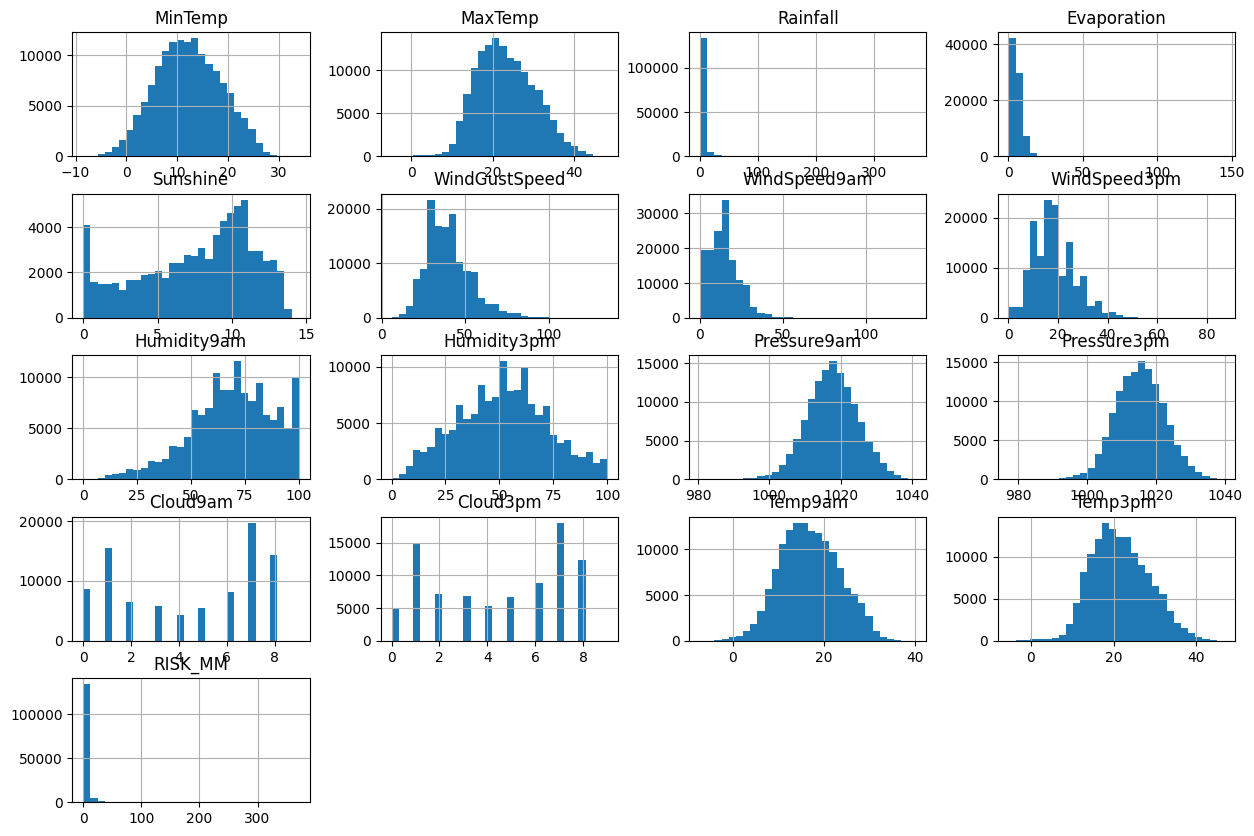

In [8]:
# Histogramas para ver la distribuci√≥n de variables num√©ricas
df.hist(bins=30, figsize=(15,10))
plt.show()

### üìä Observaciones generales sobre los histogramas de variables num√©ricas

Los histogramas permiten observar la distribuci√≥n individual de cada variable num√©rica del dataset. Esta visualizaci√≥n es fundamental para detectar sesgos, formas no normales, concentraciones de datos y posibles transformaciones necesarias antes de aplicar modelos m√°s avanzados.

A partir del an√°lisis global de los gr√°ficos, se pueden identificar algunas tendencias clave:

- Varias variables, como `Rainfall`, `Evaporation` y `WindGustSpeed`, presentan distribuciones asim√©tricas o con sesgos positivos, donde la mayor√≠a de los datos se agrupan en valores bajos, pero existen casos extremos (colas largas a la derecha). Esto sugiere que podr√≠a ser √∫til aplicar transformaciones (por ejemplo, logar√≠tmica) para normalizar su comportamiento si se desea mejorar el rendimiento de futuros modelos.

- Algunas variables como `MaxTemp`, `MinTemp`, `Pressure9am`, `Temp3pm` y otras, muestran distribuciones aproximadamente normales, lo cual es una buena se√±al, ya que permite utilizarlas directamente sin necesidad de transformaciones.

- En el caso de `Cloud9am` y `Cloud3pm`, los histogramas reflejan una distribuci√≥n discreta, probablemente por tratarse de una escala categ√≥rica del 0 al 8 (octas de nubosidad). Estas variables deben ser tratadas como ordinales o categ√≥ricas si se aplican modelos que lo requieran.

- `RISK_MM` nuevamente destaca por su comportamiento altamente sesgado, con la mayor√≠a de sus valores concentrados en 0, lo que refuerza la necesidad de revisar su significado y evaluar si aporta valor al √≠ndice clim√°tico o si debe transformarse o tratarse como variable binaria (lluvia s√≠/no).

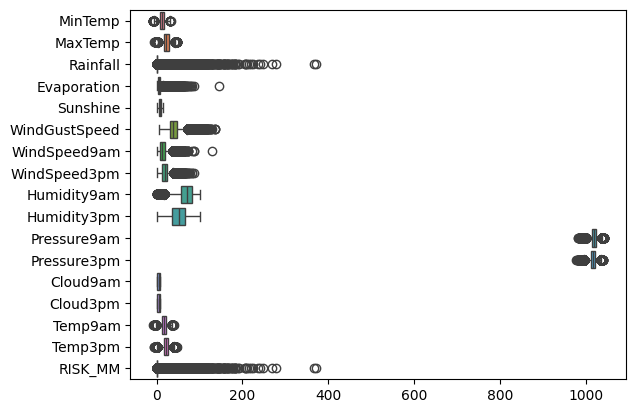

In [9]:
# Boxplot para detectar outliers en variables num√©ricas
sns.boxplot(data=df.select_dtypes(include=['float64', 'int64']), orient="h")
plt.show()

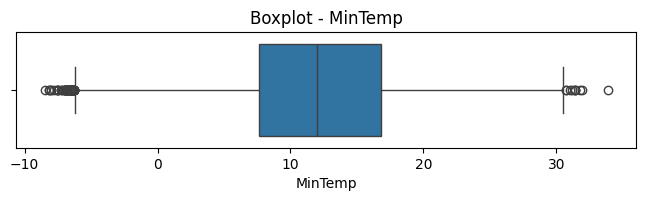

In [8]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["MinTemp"])
plt.title("Boxplot - MinTemp")
plt.show()


### üìä Boxplot - MinTemp
Esta variable presenta una distribuci√≥n bastante sim√©trica con algunos valores at√≠picos hacia ambos extremos. Podr√≠a ser √∫til para detectar eventos extremos de fr√≠o, aunque probablemente sea m√°s significativa si se combina con `Humidity9am` o `Cloud9am` para calcular riesgos de heladas o condiciones fr√≠as cr√≠ticas.

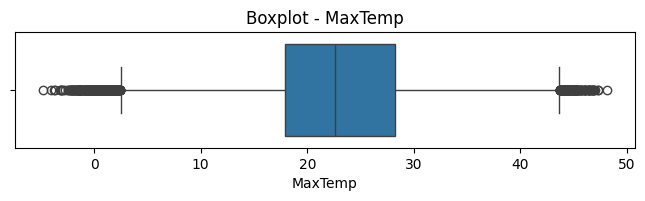

In [9]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["MaxTemp"])
plt.title("Boxplot - MaxTemp")
plt.show()

### üìä Boxplot - MaxTemp
Se observan outliers hacia temperaturas elevadas, lo que es l√≥gico en climas extremos. Es una de las variables clave para calcular el **riesgo de calor extremo**, por lo que seguramente ser√° utilizada directamente en el √≠ndice. Puede ser √∫til combinarla con `Humidity3pm` o incluso con radiaci√≥n solar si se incorpora un dataset externo.

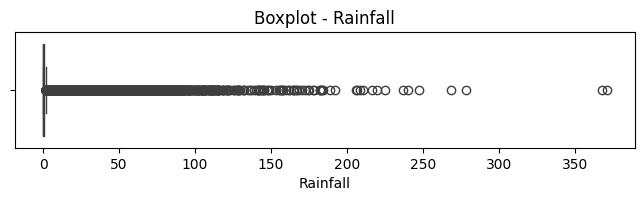

In [10]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Rainfall"])
plt.title("Boxplot - Rainfall")
plt.show()


### üìä Boxplot - Rainfall
La variable `Rainfall` muestra una distribuci√≥n muy sesgada con muchos valores cercanos a 0 y varios outliers hacia valores altos. Estos valores extremos podr√≠an representar lluvias intensas o eventos aislados de precipitaci√≥n fuerte. Es relevante para evaluar riesgo de inundaciones y podr√≠a combinarse con `Humidity3pm` para calcular un √≠ndice m√°s robusto.

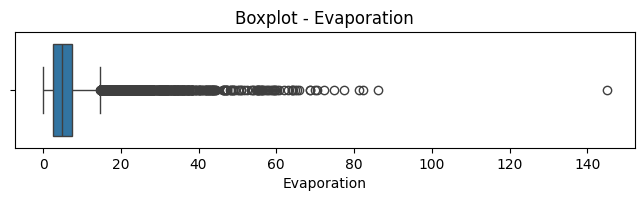

In [26]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Evaporation"])
plt.title("Boxplot - Evaporation")
plt.show()


### üìä Boxplot - Evaporation
Se observan algunos outliers pero en general la variable parece estar bien distribuida. Podr√≠a ser √∫til para detectar riesgo de **sequ√≠a**, especialmente si se combina con humedad baja y baja precipitaci√≥n. Tambi√©n puede cruzarse con datos externos como √≠ndice de vegetaci√≥n (NDVI).

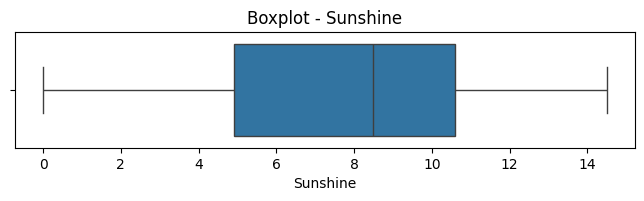

In [12]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Sunshine"])
plt.title("Boxplot - Sunshine")
plt.show()

### üìä Boxplot - Sunshine
La distribuci√≥n muestra algunos valores extremos altos, pero es bastante concentrada. Podr√≠a no ser cr√≠tica por s√≠ sola, pero combinada con alta temperatura y baja humedad puede ayudar a identificar climas √°ridos o propensos a incendios.

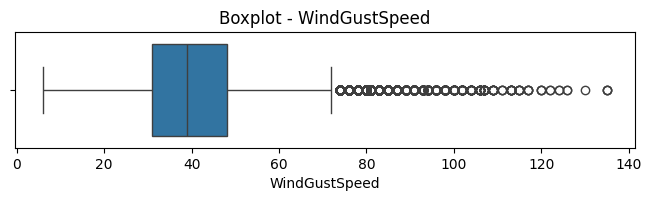

In [13]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["WindGustSpeed"])
plt.title("Boxplot - WindGustSpeed")
plt.show()


### üìä Boxplot - WindGustSpeed
Presenta outliers muy marcados hacia valores altos, lo cual es consistente con r√°fagas de viento extremas. Esta variable es **clave** para detectar **riesgo por viento extremo**, por lo que ser√° √∫til directamente en nuestro √≠ndice. Tambi√©n puede cruzarse con registros de eventos clim√°ticos severos si se consigue un dataset complementario.


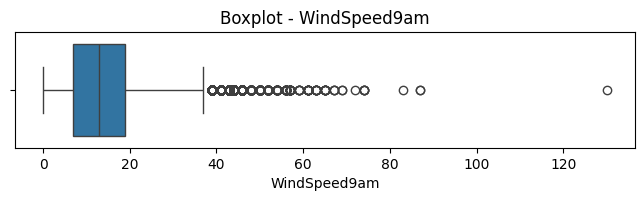

In [14]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["WindSpeed9am"])
plt.title("Boxplot - WindSpeed9am")
plt.show()

### üìä Boxplot - WindSpeed9am
Tiene distribuci√≥n relativamente estable, con algunos valores altos. Puede no ser tan cr√≠tica por s√≠ sola, pero si se analiza junto con `WindGustSpeed` puede ayudar a determinar variabilidad diaria del viento. Podr√≠a descartarse si no mejora el rendimiento del modelo.


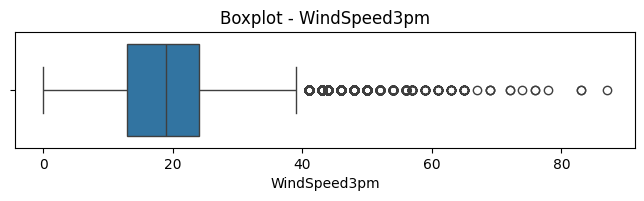

In [15]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["WindSpeed3pm"])
plt.title("Boxplot - WindSpeed3pm")
plt.show()


### üìä Boxplot - WindSpeed3pm
Similar a `WindSpeed9am`, aunque con ligera mayor dispersi√≥n. Si hay que elegir una de las dos, esta podr√≠a tener m√°s valor, ya que suele representar condiciones de viento m√°s intensas al final del d√≠a. Se puede considerar conservar esta y descartar la otra.

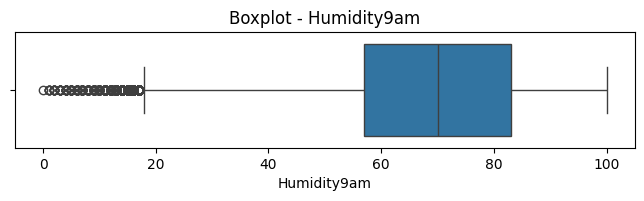

In [16]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Humidity9am"])
plt.title("Boxplot - Humidity9am")
plt.show()

### üìä Boxplot - Humidity9am
La distribuci√≥n es bastante normal, aunque con algunos outliers bajos. Por s√≠ sola no indica mucho, pero en combinaci√≥n con temperatura y nubosidad matinal puede ayudar a estimar sensaci√≥n t√©rmica o posibles nieblas.


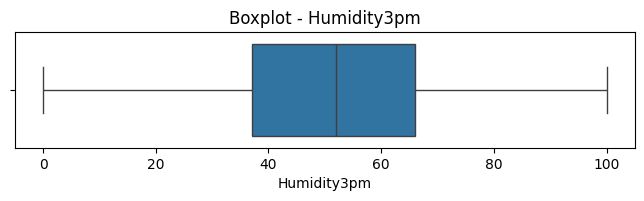

In [17]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Humidity3pm"])
plt.title("Boxplot - Humidity3pm")
plt.show()


### üìä Boxplot - Humidity3pm
Tiene una distribuci√≥n m√°s dispersa, con outliers hacia niveles bajos. Esta variable es **muy √∫til** para identificar sequ√≠a o calor extremo, especialmente si se cruza con `MaxTemp`. Sin duda ser√° parte del √≠ndice clim√°tico.

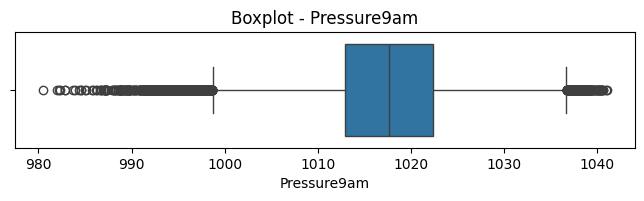

In [18]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Pressure9am"])
plt.title("Boxplot - Pressure9am")
plt.show()

### üìä Boxplot - Pressure9am
Esta variable tiene valores fuera de lo normal (~1010‚Äì1040 hPa) que podr√≠an representar errores de medici√≥n o eventos clim√°ticos raros. Podr√≠a servir como apoyo, pero no parece clave. Puede descartarse si no se correlaciona con fen√≥menos extremos.

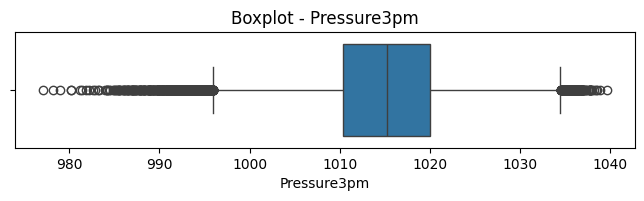

In [19]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Pressure3pm"])
plt.title("Boxplot - Pressure3pm")
plt.show()


### üìä Boxplot - Pressure3pm
Comportamiento muy similar a `Pressure9am`. Puede analizarse una de las dos para ver si tiene relaci√≥n con alg√∫n fen√≥meno (por ejemplo, presi√≥n baja previa a tormentas), pero en general podr√≠a no aportar demasiado.

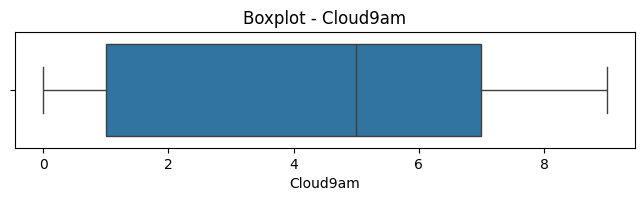

In [20]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Cloud9am"])
plt.title("Boxplot - Cloud9am")
plt.show()

### üìä Boxplot - Cloud9am
Muy concentrada y con valores enteros. Parece tratarse de una escala categ√≥rica del 0 al 8. Puede ayudar a interpretar nubosidad, pero si no se cruza con otra variable (como temperatura o humedad), su utilidad es limitada. Se puede conservar como variable auxiliar.

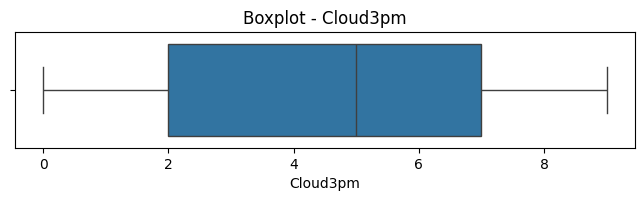

In [21]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Cloud3pm"])
plt.title("Boxplot - Cloud3pm")
plt.show()

### üìä Boxplot - Cloud3pm
Mismo caso que `Cloud9am`, pero al final del d√≠a. Podr√≠a tener m√°s valor si se relaciona con `Sunshine` para estimar d√≠as despejados. Si hay que elegir, esta podr√≠a conservarse.


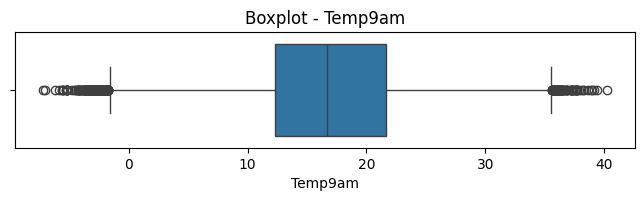

In [22]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Temp9am"])
plt.title("Boxplot - Temp9am")
plt.show()

### üìä Boxplot - Temp9am
Buena distribuci√≥n. Puede ser √∫til para estudiar la evoluci√≥n t√©rmica diaria si se combina con `MaxTemp` o `Temp3pm`. Puede usarse como variable de apoyo para construir rangos de temperatura diarios.

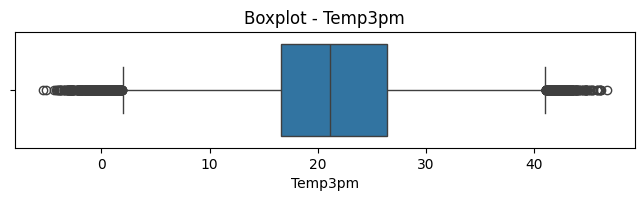

In [23]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Temp3pm"])
plt.title("Boxplot - Temp3pm")
plt.show()


### üìä Boxplot - Temp3pm
M√°s alineada con `MaxTemp`, aunque no id√©ntica. Puede ser √∫til para verificar patrones de temperatura media diurna. Probablemente no forme parte directa del √≠ndice, pero s√≠ en an√°lisis secundarios.

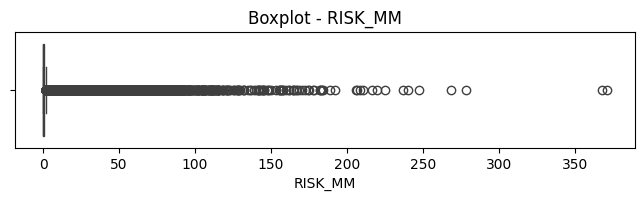

In [24]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["RISK_MM"])
plt.title("Boxplot - RISK_MM")
plt.show()

### üìä Boxplot - RISK_MM
Aunque no est√° del todo claro su significado en la descripci√≥n original, esta variable parece representar una medida asociada a riesgo (¬øquiz√°s probabilidad de lluvia?). Tiene muchos valores bajos y algunos extremos. Deber√≠a investigarse m√°s antes de decidir si se incluye o no.

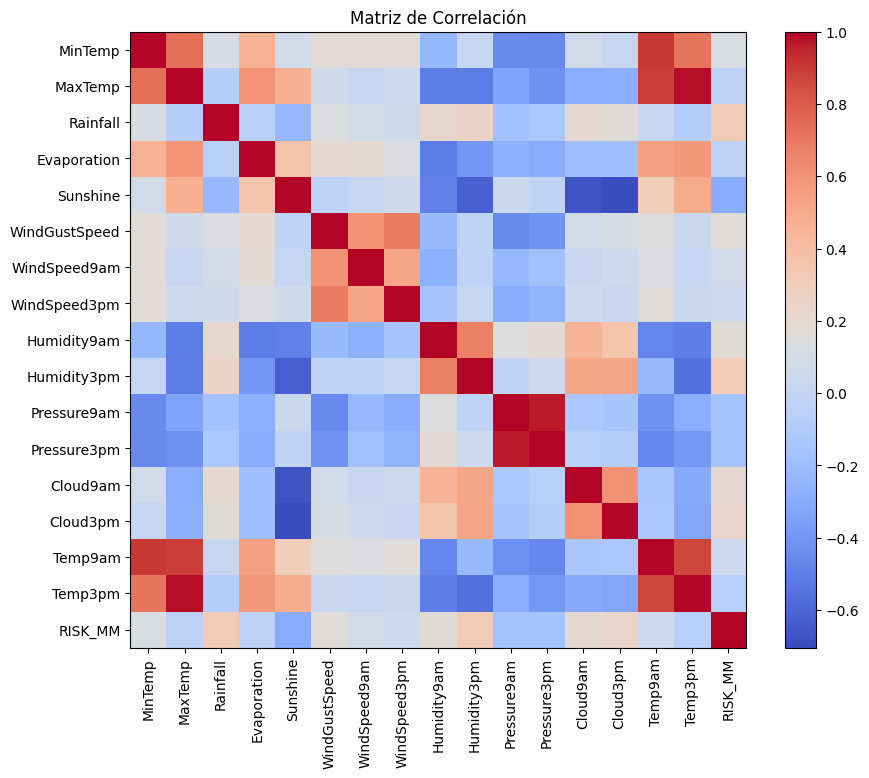

In [10]:
# Seleccionar columnas num√©ricas y calcular la matriz de correlaci√≥n
df_numeric = df.select_dtypes(include=[np.number])
corr = df_numeric.corr()

# Visualizar la matriz de correlaci√≥n
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Matriz de Correlaci√≥n")
plt.show()

### üîçObservaciones de la Matriz de Correlaci√≥n

A partir del an√°lisis de la matriz de correlaci√≥n se pueden destacar diversas relaciones entre las variables num√©ricas del conjunto de datos. Estas correlaciones permiten identificar posibles redundancias, dependencias o relaciones clave entre fen√≥menos clim√°ticos. A continuaci√≥n se presentan algunas conclusiones relevantes:

---

#### Temperatura m√≠nima (MinTemp) y temperatura m√°xima (MaxTemp)

Existe una **alta correlaci√≥n positiva** entre ambas variables, lo que es esperable dado que ambas describen el comportamiento t√©rmico diario. Esto indica que cuando la temperatura m√≠nima es alta, la m√°xima tambi√©n tiende a serlo. Aunque ambas aportan informaci√≥n, podr√≠an usarse juntas para calcular amplitud t√©rmica diaria, o elegir solo una si es necesario simplificar.

---

#### Temp9am y Temp3pm

Se observa tambi√©n una **fuerte correlaci√≥n positiva**, lo que sugiere que podr√≠an ser redundantes. Si se requiere reducir dimensionalidad, se podr√≠a conservar solo `Temp3pm` por representar una hora m√°s c√°lida del d√≠a. Sin embargo, su diferencia tambi√©n podr√≠a ser usada para calcular variabilidad t√©rmica.

---

#### WindSpeed9am, WindSpeed3pm y WindGustSpeed

Estas tres variables est√°n moderadamente correlacionadas entre s√≠, especialmente `WindSpeed3pm` con `WindGustSpeed`. Esto sugiere que los d√≠as con vientos fuertes en la tarde tambi√©n presentan r√°fagas considerables. Se podr√≠a considerar usar solo `WindGustSpeed` como indicador de condiciones extremas, ya que tiene m√°s relevancia para riesgos.

---

#### Evaporation y Sunshine

Presentan una **correlaci√≥n positiva media**, lo cual es l√≥gico, ya que mayor exposici√≥n solar tiende a generar mayor evaporaci√≥n. Esta relaci√≥n respalda que ambas pueden participar en un c√°lculo para estimar sequ√≠a o estr√©s t√©rmico. Pese a ello, ambas variables aportan matices distintos y pueden usarse conjuntamente si el modelo lo permite.

---

####  Cloud9am y Sunshine

Existe una **correlaci√≥n negativa fuerte** entre la nubosidad matinal y la cantidad de sol. Es una relaci√≥n esperada: a mayor nubosidad, menor radiaci√≥n solar. Esta relaci√≥n refuerza que una de las dos podr√≠a usarse como proxy de la otra si se desea simplificar el modelo.

---

#### Humidity3pm y Evaporation

Existe una **correlaci√≥n negativa significativa**, lo cual tiene sentido f√≠sico: a menor humedad relativa en la tarde, mayor es la capacidad de evaporaci√≥n. Esta relaci√≥n puede ser clave para construir indicadores de **sequ√≠a o deshidrataci√≥n del ambiente**, especialmente si se combina con temperatura m√°xima.

---

#### Rainfall con otras variables

La variable `Rainfall` no muestra correlaciones fuertes con ninguna otra variable del conjunto. Esto sugiere que el nivel de precipitaciones es un fen√≥meno bastante independiente, y por tanto aporta informaci√≥n √∫nica y valiosa para modelar eventos extremos como lluvias intensas o inundaciones.

---

#### RISK_MM

La variable `RISK_MM` presenta algunas correlaciones d√©biles, pero no destaca por relaciones fuertes con ninguna otra variable. Esto podr√≠a significar que representa una medida calculada con l√≥gica propia o que depende de factores externos no incluidos en este dataset. Se recomienda revisar su definici√≥n original para decidir su inclusi√≥n.

---

### Conclusi√≥n general

La matriz de correlaci√≥n permite visualizar tanto relaciones esperadas como confirmar independencia entre variables. Esto es muy √∫til para:

- Identificar variables redundantes.
- Combinar adecuadamente factores para construir indicadores.
- Detectar aquellas que aportan informaci√≥n √∫nica.

Este an√°lisis servir√° como base para seleccionar variables clave en la construcci√≥n del **√çndice de Riesgo Clim√°tico por ciudad**, priorizando aquellas que se relacionan directamente con fen√≥menos extremos como calor, viento, lluvia intensa o sequ√≠a.

# 1. Conclusiones a partir de los resultados

A partir de los histogramas, boxplots, matriz de correlaci√≥n y estad√≠sticas descriptivas, se pueden extraer varios insights:

1. **Distribuci√≥n de las variables (Histogramas):**  
   - Algunas variables (por ejemplo, *Rainfall* y *RISK_MM*) presentan distribuciones muy asim√©tricas, con la mayor√≠a de valores en rangos bajos y unos pocos extremadamente altos.  
   - *MinTemp* y *MaxTemp* parecen m√°s cercanas a distribuciones normales, aunque muestran colas que indican d√≠as inusualmente fr√≠os o c√°lidos.

2. **Outliers identificados (Boxplots):**  
   - Existen valores at√≠picos en *Rainfall*, *Evaporation* y *RISK_MM*. Podr√≠an corresponder a fen√≥menos clim√°ticos extremos o a errores de medici√≥n.  
   - Estos outliers pueden distorsionar an√°lisis estad√≠sticos, por lo que conviene confirmar su veracidad.

3. **Matriz de Correlaci√≥n:**  
   - Se aprecia una correlaci√≥n positiva notable entre *MinTemp* y *MaxTemp*.  
   - Variables como *Sunshine* y *Cloud9am/Cloud3pm* suelen relacionarse de forma inversa, aunque esto se ve limitado por la cantidad de valores faltantes.  
   - Este an√°lisis de correlaci√≥n es √∫til para la selecci√≥n de variables relevantes en futuros modelos o √≠ndices.

4. **Valores Faltantes y Duplicados:**  
   - Hay un n√∫mero significativo de valores nulos en *Evaporation*, *Sunshine*, *Cloud9am* y *Cloud3pm*. Ser√° esencial decidir si se imputan o se descartan.  
   - No hay filas duplicadas, lo que es positivo para la integridad del dataset.

5. **Variabilidad por Ubicaci√≥n:**  
   - El dataset incluye m√∫ltiples ciudades con patrones clim√°ticos distintos. La ubicaci√≥n es un factor relevante para identificar eventos extremos espec√≠ficos de cada regi√≥n.

---

# 2. Profundizar en el An√°lisis para Cumplir los Objetivos de Negocio

1. **Limpieza y Preparaci√≥n de Datos (Data Preparation):**  
   - **Imputaci√≥n de valores faltantes:**  
     - Usar la mediana o la media en variables con distribuci√≥n no muy sesgada.  
     - Emplear t√©cnicas avanzadas (KNN imputation) cuando existan correlaciones fuertes con otras variables.  
     - Considerar descartar variables si el porcentaje de datos faltantes es muy alto y su impacto en el objetivo de negocio es bajo.
   - **Tratamiento de Outliers:**  
     - Verificar si los valores extremos son reales (d√≠as con lluvias torrenciales o vientos muy fuertes) o errores.  
     - Si son reales, pueden ser cruciales para un an√°lisis de riesgo. De lo contrario, es posible corregirlos o eliminarlos.

2. **An√°lisis de Estacionalidad y Agrupaciones:**  
   - Convertir *Date* a formato datetime para extraer mes, estaci√≥n o a√±o.  
   - Agrupar por *Location* y por per√≠odos (mensuales, trimestrales) para ver tendencias y estacionalidades en diferentes regiones.

3. **Creaci√≥n de un √çndice de Riesgo Clim√°tico:**  
   - Alinear con la pregunta de negocio: ‚Äú¬øQu√© regiones de Australia tienen m√°s riesgo de fen√≥menos extremos?‚Äù  
   - Seleccionar variables clave (por ejemplo, *Rainfall*, *MaxTemp*, *WindGustSpeed*, *Humidity*).  
   - Normalizarlas y combinarlas en un score √∫nico.  
   - Calcular un ranking por ciudad o por temporada, destacando los factores que contribuyen al riesgo.

4. **Modelado Predictivo (Fases Posteriores):**  
   - Una vez limpios los datos, se pueden entrenar modelos de clasificaci√≥n o regresi√≥n para predecir la ocurrencia de eventos extremos.  
   - Esto ayudar√≠a a la compa√±√≠a a planificar recursos y mitigar riesgos.

5. **Visualizaciones Avanzadas:**  
   - Mapas geoespaciales (si hay coordenadas disponibles) para ubicar riesgos clim√°ticos en el territorio.  
   - Series de tiempo para mostrar la evoluci√≥n de variables cr√≠ticas a lo largo de las estaciones.


# Limpieza de Datos

## 1. An√°lisis de Valores Faltantes

In [11]:
# Mostrar la cantidad de valores faltantes por columna
print("Valores faltantes por columna:")
print(df.isnull().sum())

Valores faltantes por columna:
Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64


## 2. Imputaci√≥n de Valores Faltantes en Variables Num√©ricas
Para variables num√©ricas con missing moderados, imputaremos usando la mediana:

In [12]:
# Imputar la mediana para la columna MinTemp y MaxTemp
df['MinTemp'] = df['MinTemp'].fillna(df['MinTemp'].median())
df['MaxTemp'] = df['MaxTemp'].fillna(df['MaxTemp'].median())

# Verificar que se han imputado
print("Valores faltantes despu√©s de imputar MinTemp y MaxTemp:")
print(df[['MinTemp', 'MaxTemp']].isnull().sum())

Valores faltantes despu√©s de imputar MinTemp y MaxTemp:
MinTemp    0
MaxTemp    0
dtype: int64


## 3. Imputaci√≥n de Valores Faltantes en Variables Categ√≥ricas
Para variables categ√≥ricas, podemos imputar usando la moda. Por ejemplo, para RainToday:

In [13]:
# Imputar la moda para la columna RainToday
df['RainToday'] = df['RainToday'].fillna(df['RainToday'].mode()[0])

print("Valores faltantes despu√©s de imputar RainToday:")
print(df['RainToday'].isnull().sum())

Valores faltantes despu√©s de imputar RainToday:
0


## 4. Conversi√≥n de la Columna de Fechas
Es importante convertir la columna Date a formato datetime para facilitar el an√°lisis temporal:

In [14]:
# Convertir la columna Date a datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Verificar el cambio de tipo
print("Tipo de dato de Date despu√©s de la conversi√≥n:")
print(df['Date'].dtype)

Tipo de dato de Date despu√©s de la conversi√≥n:
datetime64[ns]


## 5. Detecci√≥n de Outliers con el M√©todo del IQR
Podemos usar el m√©todo del rango intercuart√≠lico (IQR) para identificar outliers:

In [15]:
# Calcular Q1, Q3 e IQR para la variable Rainfall
Q1 = df['Rainfall'].quantile(0.25)
Q3 = df['Rainfall'].quantile(0.75)
IQR = Q3 - Q1

print("Q1 de Rainfall:", Q1)
print("Q3 de Rainfall:", Q3)
print("IQR de Rainfall:", IQR)

# Identificar outliers: valores por debajo de Q1 - 1.5*IQR o por encima de Q3 + 1.5*IQR
outliers = df[(df['Rainfall'] < Q1 - 1.5 * IQR) | (df['Rainfall'] > Q3 + 1.5 * IQR)]
print("N√∫mero de outliers en Rainfall:", outliers.shape[0])

Q1 de Rainfall: 0.0
Q3 de Rainfall: 0.8
IQR de Rainfall: 0.8
N√∫mero de outliers en Rainfall: 25228


# Aplicaci√≥n de T√©cnicas Avanzadas de Imputaci√≥n con KNNImputer

Para variables como **Sunshine** y **Evaporation** que tienen un alto porcentaje de valores faltantes, podemos aplicar el m√©todo de imputaci√≥n basado en KNN (K-Nearest Neighbors). Este m√©todo utiliza la informaci√≥n de los vecinos m√°s cercanos para estimar los valores faltantes.

In [16]:
# Seleccionar las columnas que se imputar√°n
cols_to_impute = ['Sunshine', 'Evaporation']
print(cols_to_impute)

['Sunshine', 'Evaporation']


In [ ]:
# Crear el objeto KNNImputer, usando 5 vecinos (puedes ajustar n_neighbors seg√∫n convenga)
imputer = KNNImputer(n_neighbors=5)

# Aplicar la imputaci√≥n a las columnas seleccionadas
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

# Verificar que ya no hay valores faltantes en estas columnas
print("Valores faltantes en 'Sunshine' y 'Evaporation' despu√©s de la imputaci√≥n:")
print(df[cols_to_impute].isnull().sum())

# Evaluaci√≥n de la Relevancia de los Outliers

Para determinar si los outliers en la variable *Rainfall* aportan informaci√≥n relevante (por ejemplo, si representan eventos extremos reales como lluvias torrenciales) o si son errores de medici√≥n, se pueden realizar varios an√°lisis. A continuaci√≥n, se presentan comandos y m√©todos que te ayudar√°n a investigar:

In [ ]:
# Crear una columna que indique si el valor es outlier
df['Rainfall_Outlier'] = ((df['Rainfall'] < Q1 - 1.5 * IQR) | (df['Rainfall'] > Q3 + 1.5 * IQR)).astype(int)

# Mostrar el conteo total de outliers
print("N√∫mero de outliers (con indicador en columna):", df['Rainfall_Outlier'].sum())

In [ ]:
# Crear subconjuntos de datos
outlier_data = df[df['Rainfall_Outlier'] == 1]
non_outlier_data = df[df['Rainfall_Outlier'] == 0]

print("Estad√≠sticas de Rainfall para Outliers:")
print(outlier_data['Rainfall'].describe())

print("\nEstad√≠sticas de Rainfall para No Outliers:")
print(non_outlier_data['Rainfall'].describe())

In [ ]:
# Sumar outliers por ciudad (Location)
outliers_por_ciudad = df.groupby('Location')['Rainfall_Outlier'].sum()
print("N√∫mero de outliers por ciudad:")
print(outliers_por_ciudad.sort_values(ascending=False))

In [ ]:
# Extraer el a√±o de la columna Date
df['Year'] = df['Date'].dt.year

# Conteo de outliers por a√±o
outliers_por_a√±o = df.groupby('Year')['Rainfall_Outlier'].sum()
print("N√∫mero de outliers por a√±o:")
print(outliers_por_a√±o)

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Rainfall', hue='Rainfall_Outlier', bins=50, kde=True)
plt.title("Histograma de Rainfall con Indicador de Outliers")
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Rainfall_Outlier', y='Rainfall', data=df)
plt.title("Distribuci√≥n de Rainfall: Outliers vs No Outliers")
plt.xlabel("0: No Outlier, 1: Outlier")
plt.show()


## ¬øPor qu√© mantener la variable *Rainfall* con los outliers intactos?

En un **An√°lisis de Riesgo Clim√°tico o Fen√≥menos Extremos**, los outliers representan eventos de lluvia intensa que pueden desencadenar inundaciones o afectaciones severas. Precisamente porque son eventos raros pero de gran impacto, es fundamental conservarlos en la variable:

1. **Capturan la realidad de los fen√≥menos extremos:**  
   - Las lluvias torrenciales, aunque infrecuentes, son las que m√°s riesgo generan. Eliminar o modificar estos valores puede subestimar la verdadera magnitud de las precipitaciones.

2. **Permiten identificar patrones de riesgo:**  
   - Analizar d√≥nde y cu√°ndo ocurren estos valores extremos (por ciudad, a√±o o estaci√≥n) facilita la detecci√≥n de regiones y periodos con alta probabilidad de inundaciones.

3. **Mantienen la interpretabilidad:**  
   - Conservar *Rainfall* en mil√≠metros permite comunicar de forma directa cu√°nta precipitaci√≥n se registra, sin perder la referencia real de lo que significan esos valores.

4. **Son cr√≠ticos para la construcci√≥n de √≠ndices de riesgo:**  
   - En un √≠ndice de riesgo clim√°tico, las variables que miden fen√≥menos extremos (como *Rainfall*) deben reflejar fielmente su impacto. Suavizar o eliminar estos valores podr√≠a ocultar los verdaderos eventos de mayor peligro.

# Extracci√≥n de Caracter√≠sticas Temporales

Una vez que hemos preparado y limpiado nuestros datos, el siguiente paso es extraer informaci√≥n temporal de la columna **Date**. Esto es fundamental para detectar patrones estacionales, tendencias a lo largo del tiempo y posibles eventos c√≠clicos que afectan el clima.

In [ ]:
# Extraer caracter√≠sticas b√°sicas de la fecha
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0 = lunes, 6 = domingo
df['Quarter'] = df['Date'].dt.quarter

# Funci√≥n para asignar la estaci√≥n (season) en base al mes, considerando el calendario australiano
def get_season(month):
    if month in [12, 1, 2]:
        return 'Verano'
    elif month in [3, 4, 5]:
        return 'Oto√±o'
    elif month in [6, 7, 8]:
        return 'Invierno'
    else:  # 9, 10, 11
        return 'Primavera'

# Aplicar la funci√≥n para crear una nueva columna 'Season'
df['Season'] = df['Month'].apply(get_season)

# Visualizar las primeras filas para confirmar la extracci√≥n
print(df[['Date', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'Season']].head())

## Importancia de la Extracci√≥n de Caracter√≠sticas Temporales

- **Detecci√≥n de Tendencias y Estacionalidades:**  
  Permite identificar patrones recurrentes y ciclos estacionales, fundamentales para comprender el comportamiento clim√°tico.

- **An√°lisis de Eventos Extremos:**  
  Facilita segmentar el an√°lisis por estaciones o trimestres, ayudando a determinar si ciertos periodos presentan mayor riesgo de fen√≥menos extremos.

- **Soporte para Modelado Predictivo:**  
  Las caracter√≠sticas temporales mejoran la precisi√≥n de los modelos al capturar variaciones c√≠clicas en el clima.

- **Segmentaci√≥n Geogr√°fica y Temporal:**  
  Combinado con la variable *Location*, posibilita an√°lisis comparativos por regi√≥n y la detecci√≥n de per√≠odos cr√≠ticos para eventos extremos.


## An√°lisis de Patrones Temporales y Geogr√°ficos

### 1. An√°lisis por Estaci√≥n y Mes


In [ ]:
# Calcular el promedio de Rainfall por estaci√≥n
season_rainfall = df.groupby('Season')['Rainfall'].mean()
print("Promedio de Rainfall por Estaci√≥n:")
print(season_rainfall)

# Visualizaci√≥n con un barplot
plt.figure(figsize=(8,6))
sns.barplot(x=season_rainfall.index, y=season_rainfall.values)
plt.title("Promedio de Rainfall por Estaci√≥n")
plt.ylabel("Rainfall (mm)")
plt.show()

### Distribuci√≥n de Rainfall por Mes

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Month', y='Rainfall', data=df)
plt.title("Distribuci√≥n de Rainfall por Mes")
plt.xlabel("Mes")
plt.ylabel("Rainfall (mm)")
plt.show()

## An√°lisis de Tendencias a lo Largo del Tiempo

### Evoluci√≥n de MaxTemp a lo largo de los A√±os
Agrupa por el a√±o para analizar c√≥mo ha evolucionado la temperatura m√°xima con el tiempo. Esto puede ayudar a identificar tendencias o anomal√≠as en el clima.

In [ ]:
# Calcular el promedio de MaxTemp por a√±o
year_maxTemp = df.groupby('Year')['MaxTemp'].mean()
print("Promedio de MaxTemp por A√±o:")
print(year_maxTemp)

# Gr√°fico de l√≠nea para visualizar la evoluci√≥n de MaxTemp
plt.figure(figsize=(10,6))
year_maxTemp.plot(marker='o')
plt.title("Evoluci√≥n de MaxTemp a lo largo de los A√±os")
plt.xlabel("A√±o")
plt.ylabel("MaxTemp (¬∞C)")
plt.show()

## An√°lisis Combinado: Ubicaci√≥n y Temporalidad

### Outliers y Promedios por Ubicaci√≥n y Estaci√≥n
Puedes combinar la informaci√≥n de ubicaci√≥n y temporal para identificar qu√© regiones presentan fen√≥menos extremos en determinadas estaciones.

In [ ]:
# Promedio de Rainfall por Location y Season
location_season = df.groupby(['Location', 'Season'])['Rainfall'].mean().unstack()
print("Promedio de Rainfall por Location y Season:")
print(location_season.head())

# Visualizaci√≥n de un heatmap para ver diferencias entre ciudades y estaciones
plt.figure(figsize=(12,8))
sns.heatmap(location_season, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title("Promedio de Rainfall por Location y Season")
plt.xlabel("Season")
plt.ylabel("Location")
plt.show()

# An√°lisis e Interpretaci√≥n de Patrones Temporales y Geogr√°ficos

## 1. Rainfall por Estaci√≥n y por Mes

1. **Promedio de Rainfall por Estaci√≥n**  
   - El gr√°fico de barras muestra que **Verano** registra, en promedio, la mayor cantidad de lluvia, seguido de **Primavera** y **Oto√±o**, mientras que **Invierno** presenta los valores m√°s bajos.  
   - Esto podr√≠a indicar un patr√≥n estacional donde los meses de verano concentran mayor riesgo de lluvias intensas (especialmente en zonas tropicales o costeras).

2. **Distribuci√≥n de Rainfall por Mes**  
   - El boxplot revela que la variable *Rainfall* es muy asim√©trica en todos los meses, con numerosos outliers (episodios de lluvia intensa).  
   - Aunque cada mes tiene valores altos ocasionales, se observa que ciertos meses (por ejemplo, en el rango de noviembre a marzo) podr√≠an presentar una mayor frecuencia de lluvias considerables, dependiendo de la regi√≥n.

**Implicaci√≥n para el Riesgo Clim√°tico:**  
- Al saber en qu√© estaci√≥n o mes se concentran las precipitaciones m√°s fuertes, puedes identificar per√≠odos con mayor probabilidad de inundaciones o afectaciones en agricultura, log√≠stica, etc.

---

## 2. Evoluci√≥n de MaxTemp a lo Largo de los A√±os

1. **Tendencia General**  
   - El gr√°fico de l√≠neas muestra fluctuaciones de la temperatura m√°xima promedio entre 2008 y 2017, con valores que oscilan aproximadamente entre 22 ¬∞C y 25.2 ¬∞C.  
   - El a√±o **2016** destaca por ser uno de los m√°s c√°lidos dentro del periodo analizado, mientras que **2012** presenta uno de los promedios m√°s bajos.

2. **Variabilidad Interanual**  
   - No se observa una tendencia claramente creciente o decreciente de manera constante; m√°s bien, hay **variaciones anuales** que podr√≠an atribuirse a factores clim√°ticos globales (El Ni√±o, La Ni√±a) o regionales.

**Implicaci√≥n para el Riesgo Clim√°tico:**  
- Conocer los a√±os m√°s c√°lidos permite identificar posibles olas de calor que afecten la salud p√∫blica, la demanda energ√©tica (por ejemplo, uso de aire acondicionado) o el estr√©s h√≠drico en la agricultura.

---

## 3. An√°lisis Combinado: Ubicaci√≥n y Estaci√≥n (Heatmap)

1. **Patrones Regionales y Estacionales**  
   - El heatmap muestra c√≥mo var√≠a el promedio de *Rainfall* seg√∫n la **ciudad (Location)** y la **estaci√≥n (Season)**.  
   - Algunas ciudades costeras o tropicales (p. ej., **Darwin, Cairns**) presentan promedios de lluvia mucho m√°s elevados en ciertas estaciones (probablemente verano), mientras que zonas m√°s templadas o √°ridas (p. ej., **AliceSprings, Woomera**) registran valores menores.

2. **Identificaci√≥n de Zonas Cr√≠ticas**  
   - Ciudades con colores m√°s intensos (valores altos) en una o varias estaciones podr√≠an considerarse zonas de **mayor riesgo de eventos extremos** (inundaciones o tormentas).

**Implicaci√≥n para el Riesgo Clim√°tico:**  
- Combinar informaci√≥n temporal (estaci√≥n) con la localizaci√≥n geogr√°fica es clave para **priorizar** medidas preventivas en las zonas y temporadas donde las lluvias son m√°s frecuentes o intensas.


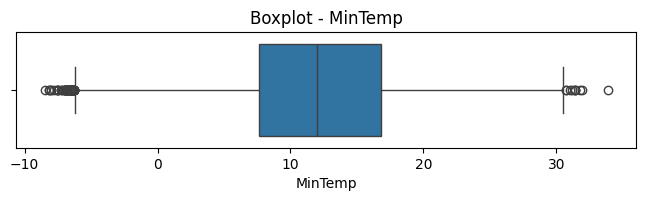

In [5]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["MinTemp"])
plt.title("Boxplot - MinTemp")
plt.show()


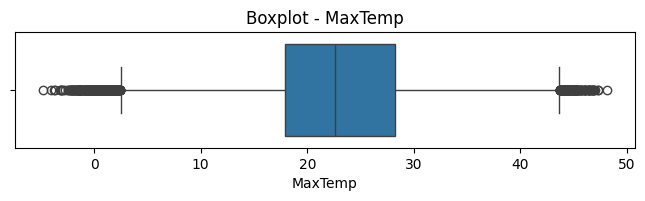

In [6]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["MaxTemp"])
plt.title("Boxplot - MaxTemp")
plt.show()


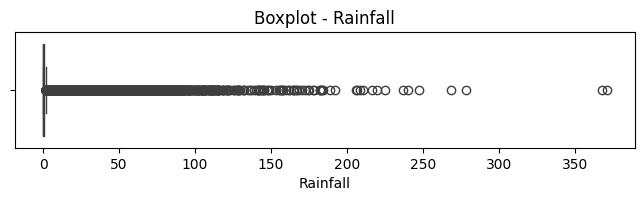

In [7]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Rainfall"])
plt.title("Boxplot - Rainfall")
plt.show()
